## Reproduce results of FEBRL dataset

In [2]:
import recordlinkage as rl, pandas as pd, numpy as np
from recordlinkage.datasets import load_febrl3, load_febrl4
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice,randint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn import tree

In [3]:
def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name')
    c.string('given_name_soundex', 'given_name_soundex', method='jarowinkler', label='y_name_soundex')
    c.string('given_name_nysiis', 'given_name_nysiis', method='jarowinkler', label='y_name_nysiis')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname')
    c.string('surname_soundex', 'surname_soundex', method='jarowinkler', label='y_surname_soundex')
    c.string('surname_nysiis', 'surname_nysiis', method='jarowinkler', label='y_surname_nysiis')
    c.exact('street_number', 'street_number', label='y_street_number')
    c.string('address_1', 'address_1', method='levenshtein', threshold=0.7, label='y_address1')
    c.string('address_2', 'address_2', method='levenshtein', threshold=0.7, label='y_address2')
    c.exact('postcode', 'postcode', label='y_postcode')
    c.exact('day', 'day', label='y_day')
    c.exact('month', 'month', label='y_month')
    c.exact('year', 'year', label='y_year')
        
    # Build features
    feature_vectors = c.compute(links, df)
    return feature_vectors

In [4]:
def process_data(df):
    df["rec_id"] = df.index.values.tolist()
    true_pairs = [[],[]]
    false_pairs = [[],[]]
    
    unique_ids = df["match_id"].drop_duplicates()
    for i in range(0,len(unique_ids)):
        if unique_ids[i] == -1:
            continue
        row_with_same_id = df.loc[df['match_id'] == unique_ids[i]]
        for j in range(0,len(row_with_same_id)):
            for k in range(j+1, len(row_with_same_id)):
                true_pairs[0].append(row_with_same_id.iloc[j]["rec_id"])
                true_pairs[1].append(row_with_same_id.iloc[k]["rec_id"])
                false_pair_ids = choice(unique_ids, 2)
                false_pair1_data = df.loc[df['match_id'] == false_pair_ids[0]]
                false_pair2_data = df.loc[df['match_id'] == false_pair_ids[1]] 
                false_pairs[0].append(false_pair1_data.iloc[randint(len(false_pair1_data))]["rec_id"])
                false_pairs[1].append(false_pair2_data.iloc[randint(len(false_pair2_data))]["rec_id"])

    true_pairs = pd.MultiIndex.from_arrays([true_pairs[0],true_pairs[1]])
    false_pairs = pd.MultiIndex.from_arrays([false_pairs[0],false_pairs[1]])
    
    true_data = extract_features(df, true_pairs)   
    false_data = extract_features(df, false_pairs)
    
    data = []
    label = []
    data.extend(true_data.values.tolist())
    data.extend(false_data.values.tolist())
    for i in range(0,len(data)):
        if i < len(true_data):
            label.append(1)
        else:
            label.append(0)
    data, label = shuffle(data, label)
    return data, label


In [5]:
df_train = pd.read_csv("febrl3_UNSW.csv", index_col = "rec_id")
df_train['postcode'] = df_train['postcode'].astype(str)
df_train['given_name_soundex'] = phonetic(df_train['given_name'], method='soundex')
df_train['given_name_nysiis'] = phonetic(df_train['given_name'], method='nysiis')
df_train['surname_soundex'] = phonetic(df_train['surname'], method='soundex')
df_train['surname_nysiis'] = phonetic(df_train['surname'], method='nysiis')

X_train, y_train = process_data(df_train)

In [6]:
df_test = pd.read_csv("febrl4_UNSW.csv", index_col = "rec_id")
blocking_fields = ["given_name", "surname", "postcode"]
all_pairs = set()
all_pairs_with_match_id = set()
true_pair_num = 0
unique_ids = df_test["match_id"].drop_duplicates()
for i in range(0,len(unique_ids)):
    if unique_ids[i] == -1:
        continue
    row_with_same_id = df_test.loc[df_test['match_id'] == unique_ids[i]]
    for j in range(0,len(row_with_same_id)):
            true_pair_num += j

for field in blocking_fields:
    pairs_field = rl.BlockIndex(on=field).index(df_test)
    pairs_field_id = rl.BlockIndex(on=[field,"match_id"]).index(df_test)
    all_pairs_with_match_id = all_pairs_with_match_id.union(pairs_field_id)
    all_pairs = pairs_field.union(all_pairs)
    print("Number of pairs of matched "+ field +": "+str(len(pairs_field)), ", detected ",
         len(pairs_field_id),'/'+ str(true_pair_num) + " true matched pairs, missed " + 
          str(true_pair_num-len(pairs_field_id)) )
print("Number of pairs of at least 1 field matched: " + str(len(all_pairs)), ", detected ",
     len(all_pairs_with_match_id),'/'+str(true_pair_num) + " true matched pairs, missed " + 
          str(true_pair_num-len(all_pairs_with_match_id)) )

Number of pairs of matched given_name: 154898 , detected  3287 /5000 true matched pairs, missed 1713
Number of pairs of matched surname: 170843 , detected  3325 /5000 true matched pairs, missed 1675
Number of pairs of matched postcode: 53197 , detected  4219 /5000 true matched pairs, missed 781
Number of pairs of at least 1 field matched: 372073 , detected  4894 /5000 true matched pairs, missed 106


In [7]:
df_test['postcode'] = df_test['postcode'].astype(str)
df_test['given_name_soundex'] = phonetic(df_test['given_name'], method='soundex')
df_test['given_name_nysiis'] = phonetic(df_test['given_name'], method='nysiis')
df_test['surname_soundex'] = phonetic(df_test['surname'], method='soundex')
df_test['surname_nysiis'] = phonetic(df_test['surname'], method='nysiis')

df_X_test = extract_features(df_test, all_pairs)
data = df_X_test.values.tolist()
labels = []
feature_index = df_X_test.index
#print(feature_index)
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels.append(1)
    else:
        labels.append(0)
        
X_test, y_test = shuffle(data, labels)

In [8]:
def evaluation(Y_true, Y_pred):
    precision = precision_score(Y_true, Y_pred)
    f1score = f1_score(Y_true, Y_pred)
    confusion_mat= confusion_matrix(Y_true, Y_pred).ravel()
    sensitivity = recall_score(Y_true, Y_pred)
    no_false = confusion_mat[1]+confusion_mat[2]
    no_links_found = np.count_nonzero(Y_pred)
    
    return no_false,confusion_mat,precision,sensitivity,no_links_found,f1score

In [9]:
def train (model, params, hyperparameter):
    if model == 'svm': 
        md = svm.SVC(C = hyperparameter, kernel = params) 
    elif model == 'lg': 
        md = LogisticRegression(C=hyperparameter, penalty = params,class_weight=None, dual=False, fit_intercept=True, 
                                   intercept_scaling=1, max_iter=5000, multi_class='ovr', 
                                   n_jobs=1, random_state=None)
        if(params == 'l1'):
            md.solver = 'liblinear'
    elif model == 'nn': 
        md = MLPClassifier(solver='lbfgs', alpha=hyperparameter, hidden_layer_sizes=(256, ), 
                              activation = params,random_state=None, batch_size='auto', 
                              learning_rate='constant',  learning_rate_init=0.001, 
                              power_t=0.5, max_iter=10000, shuffle=True, 
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                              nesterovs_momentum=True, early_stopping=False, 
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    elif model == 'knn':
        md = NearestCentroid()
        
    return md

In [10]:
model = {'svm':['linear','rbf'],'lg':['l1','l2'],'nn':['relu','logistic']}
#model = {'knn':['default']}
hyperparameters = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000]
plot_f1score = []

for key in model.keys():
    for value in model[key]:
        precision = []
        sensitivity = []
        f1score = []
        nb_false = []
        print("Model:",key,", Param:",value)
        for hyperparameter in hyperparameters:
            md = train(key,value, hyperparameter)
            md.fit(X_train,y_train)
            
            prediction = md.predict(X_test)
            no_false,_,pre,sen,_,f1= evaluation(y_test, prediction)
            precision.append(pre)
            sensitivity.append(sen)
            f1score.append(f1)
            nb_false.append(no_false)
        plot_f1score.append(f1score)
        print("No_false:",nb_false,"\n")
        print("Precision:",precision,"\n")  
        print("Sensitivity:",sensitivity,"\n")
        print("F1-score:", f1score,"\n")
        print("")

Model: svm , Param: linear
No_false: [288, 369, 176, 457, 559, 638, 1098, 1220, 1524, 1399, 1376, 1401, 1408, 1404, 1408, 1408, 1407, 1406, 1405, 1410] 

Precision: [0.9551383399209487, 0.9330143540669856, 0.9676843774781919, 0.9163069994370426, 0.8990977720493464, 0.886066763425254, 0.8171791443850267, 0.8009501965923984, 0.7628705148205929, 0.7781314658602578, 0.7810802173218281, 0.7779723062231418, 0.7771065182829888, 0.7776010181355393, 0.7771065182829888, 0.7771065182829888, 0.7772300842741294, 0.77735368956743, 0.7774773341816447, 0.7768595041322314] 

Sensitivity: [0.9875357580711075, 0.9961176951369023, 0.9973436861463016, 0.9977523498161014, 0.9977523498161014, 0.9979566816510013, 0.9991826726604005, 0.9989783408255006, 0.9991826726604005, 0.9989783408255006, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008] 

F1-score: [0.971066

C:\Users\89245\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No_false: [4894, 4227, 5216, 4114, 882, 918, 1571, 657, 399, 530, 727, 760, 786, 797, 791, 796, 796, 798, 797, 799] 

Precision: [0.0, 0.54006006006006, 0.48394495412844035, 0.5437415881561238, 0.8523006673691605, 0.8458594293667363, 0.7585992217898833, 0.8844129921974233, 0.9267134991456237, 0.9045235446792733, 0.8729192768927868, 0.8677935943060499, 0.8635398230088496, 0.8618618618618619, 0.8626480466678451, 0.861886259272342, 0.861886259272342, 0.8615819209039548, 0.861734063217376, 0.8614298323036187] 

Sensitivity: [0.0, 0.9186759297098488, 0.9916223947691051, 0.9906007355946056, 0.9916223947691051, 0.9934613812832039, 0.9959133633020024, 0.9959133633020024, 0.9973436861463016, 0.9969350224765018, 0.996526358806702, 0.996526358806702, 0.9969350224765018, 0.9969350224765018, 0.9971393543114018, 0.9971393543114018, 0.9971393543114018, 0.9971393543114018, 0.9971393543114018, 0.9971393543114018] 

F1-score: [0.0, 0.6802329979574855, 0.6504490014743333, 0.7020999275887039, 0.9166981488

C:\Users\89245\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No_false: [9351, 14021, 22855, 10473, 11150, 5491, 4520, 4252, 3572, 1933, 837, 602, 412, 360, 356, 370, 392, 400, 4894, 367179] 

Precision: [0.34347123691789, 0.2586088336418937, 0.17627338596301503, 0.31838010287128066, 0.304938887503118, 0.47124000385393583, 0.5198809270678291, 0.5351203501094092, 0.5781508630882005, 0.7171139463264409, 0.8550673901627867, 0.892035074899525, 0.9242711094282469, 0.9342911877394636, 0.9358432577794852, 0.9353348729792148, 0.9348918083462133, 0.9354651162790698, 0.0, 0.013153332813722038] 

Sensitivity: [0.9991826726604005, 0.9989783408255006, 0.9991826726604005, 0.9991826726604005, 0.9991826726604005, 0.9993870044953004, 0.9991826726604005, 0.9993870044953004, 0.9991826726604005, 0.9991826726604005, 0.9981610134859011, 0.9977523498161014, 0.9975480179812015, 0.996526358806702, 0.9955046996322027, 0.9930527176134042, 0.9887617490805067, 0.9863097670617083, 0.0, 1.0] 

F1-score: [0.5112121687313784, 0.410857599058784, 0.2996782595373066, 0.482891423492

C:\Users\89245\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\89245\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\89245\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No_false: [36113, 15621, 26045, 22663, 8307, 4674, 3098, 1509, 1024, 754, 400, 374, 363, 373, 380, 398, 4894, 4894, 367179, 4894] 

Precision: [0.11927120173662772, 0.23848066702423326, 0.15809382173224273, 0.17750190569530655, 0.37063149116822075, 0.511508683825068, 0.6125877632898696, 0.7651574494751684, 0.8275220040622884, 0.8676731793960923, 0.9265375854214123, 0.9312977099236641, 0.933920704845815, 0.9347951529140219, 0.9357142857142857, 0.9344800927715501, 0.0, 0.0, 0.013153332813722038, 0.0] 

Sensitivity: [0.9991826726604005, 0.9993870044953004, 0.9991826726604005, 0.9991826726604005, 0.9989783408255006, 0.9989783408255006, 0.998365345320801, 0.9979566816510013, 0.9989783408255006, 0.9981610134859011, 0.9973436861463016, 0.9971393543114018, 0.9963220269718022, 0.9930527176134042, 0.9903964037597057, 0.9879444217409072, 0.0, 0.0, 1.0, 0.0] 

F1-score: [0.2131043950057743, 0.3850726292170216, 0.27299371946964407, 0.301451776962673, 0.5406690627591927, 0.6765845557708275, 0.759285

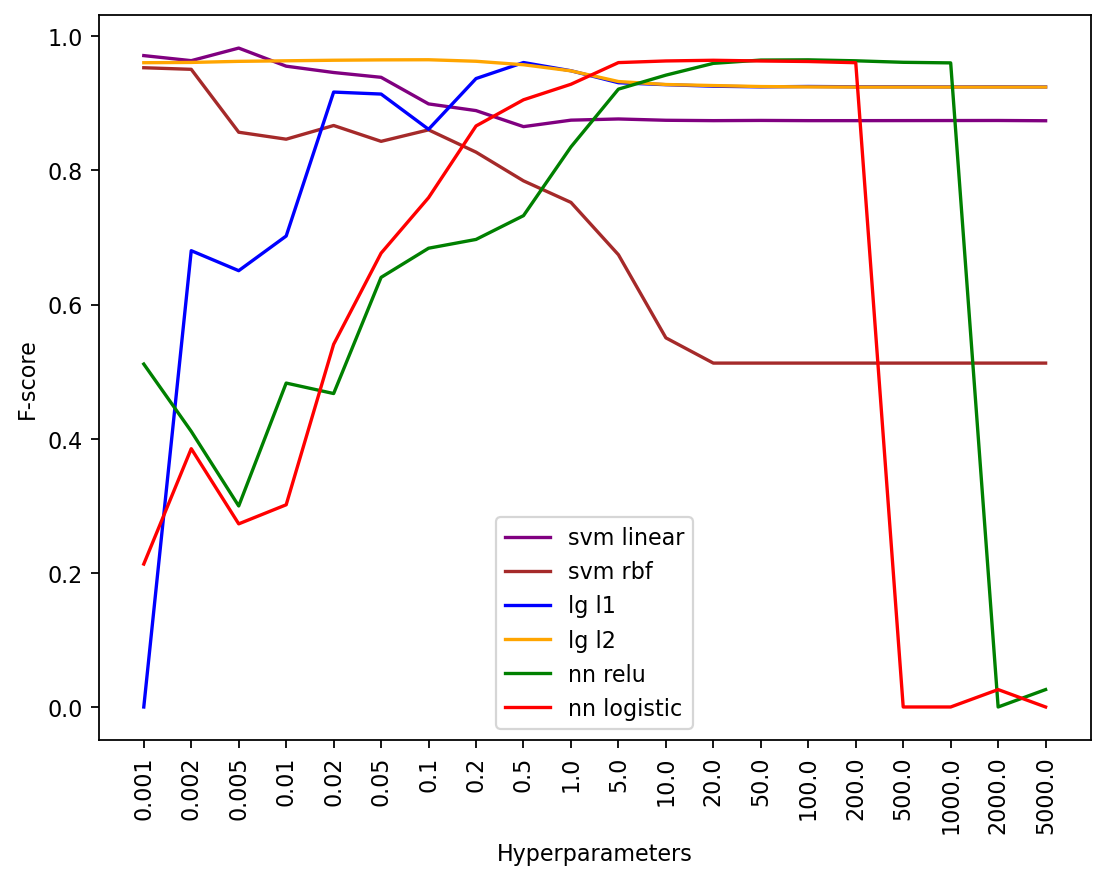

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

color = ['purple','brown','blue','orange','green','red']
figure(figsize=(8, 6), dpi=160)
count = 0
for key in model.keys():
    for value in model[key]:
        plt.plot(np.array(hyperparameters).astype('str'), plot_f1score[count], label = key+' '+value,color=color[count])
        count += 1
        
plt.xlabel('Hyperparameters')
plt.ylabel('F-score')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [12]:
count = 0
bagging_model =['svm','lg','nn']
bagging_param =['','','']
bagging_hyperparams = [0,0,0]
bagging_f1score=[0,0,0]
for key in model.keys():
    for value in model[key]:
        max_f1score = 0
        index = 0
        for i in range(0,len(plot_f1score[count])):
            if plot_f1score[count][i] > max_f1score:
                index = i
                max_f1score = plot_f1score[count][i]
        pos = count//2
        if (max_f1score > bagging_f1score[pos]):
            bagging_param[pos] = value
            bagging_hyperparams[pos] = hyperparameters[index]
            bagging_f1score[pos] = max_f1score
        print("Model:",key,", Param:",value,", hyperparameter:",hyperparameters[index],", f1score:",max_f1score)
        count += 1

Model: svm , Param: linear , hyperparameter: 0.005 , f1score: 0.9822901992352586
Model: svm , Param: rbf , hyperparameter: 0.001 , f1score: 0.9529860228716645
Model: lg , Param: l1 , hyperparameter: 0.5 , f1score: 0.9607322113965162
Model: lg , Param: l2 , hyperparameter: 0.1 , f1score: 0.9648966676554929
Model: nn , Param: relu , hyperparameter: 100 , f1score: 0.9647524752475247
Model: nn , Param: logistic , hyperparameter: 20 , f1score: 0.9641127039050915


In [16]:
Fold_param = 10
kf = KFold(n_splits=Fold_param)
bagging_models_score = [[],[],[]]
bagging_models_binary_score = [[],[],[]]
for i in range(0,len(bagging_model)):    
    fold_score = []
    for index, _ in kf.split(X_train):
        md =  train(bagging_model[i], bagging_param[i], bagging_hyperparams[i])
        md.fit(np.array(X_train)[index],np.array(y_train)[index])
        if (len(fold_score) == 0):
            fold_score = md.predict(X_test)
        else:
            fold_score += md.predict(X_test)
    bagging_models_score[i] = fold_score/Fold_param
    bagging_models_binary_score[i] = np.where(fold_score/Fold_param>0.5,1, 0)
    no_false,_,precision,sensitivity,_,f1score = evaluation(y_test, bagging_models_binary_score[i])
    print(bagging_model[i], "No_false:",no_false,"Precision:",precision,"Sensitivity:",sensitivity,"F1-score:", f1score)
    print("")


stacking_prediction = np.average(bagging_models_score,axis=0)
stacking_score = np.where(stacking_prediction>0.99,1, 0)
no_false,_,precision,sensitivity,_,f1score  = evaluation(y_test, stacking_score)
print("Stacking: No_false:",no_false,"Precision:",precision,"Sensitivity:",sensitivity,"F1-score:", f1score)

svm No_false: 183 Precision: 0.966343298356761 Sensitivity: 0.9973436861463016 F1-score: 0.9815987933634993

lg No_false: 355 Precision: 0.9351869606903164 Sensitivity: 0.996526358806702 F1-score: 0.9648827777228212

nn No_false: 361 Precision: 0.93511230562488 Sensitivity: 0.9953003677973028 F1-score: 0.9642680391962782

Stacking: No_false: 135 Precision: 0.9779072102831894 Sensitivity: 0.994891704127503 F1-score: 0.9863263445761167


In [17]:
new_bagging_model =['svm','lg','nn','knn']
new_bagging_param =bagging_param +['']
new_bagging_hyperparams = bagging_hyperparams+[0]

In [18]:
Fold_param = 10
kf = KFold(n_splits=Fold_param)
new_bagging_models_score = [[],[],[],[]]
new_bagging_models_binary_score = [[],[],[],[]]
for i in range(0,len(new_bagging_model)):    
    fold_score = []
    for index, _ in kf.split(X_train):
        md =  train(new_bagging_model[i], new_bagging_param[i], new_bagging_hyperparams[i])
        md.fit(np.array(X_train)[index],np.array(y_train)[index])
        if (len(fold_score) == 0):
            fold_score = md.predict(X_test)
        else:
            fold_score += md.predict(X_test)
    new_bagging_models_score[i] = fold_score/Fold_param
    new_bagging_models_binary_score[i] = np.where(fold_score/Fold_param>0.5,1, 0)
    no_false,_,precision,sensitivity,_,f1score = evaluation(y_test, new_bagging_models_binary_score[i])
    print(new_bagging_model[i], "No_false:",no_false,"Precision:",precision,"Sensitivity:",sensitivity,"F1-score:", f1score)
    print("")


new_stacking_prediction = np.average(new_bagging_models_score,axis=0)
new_stacking_score = np.where(new_stacking_prediction>0.99,1, 0)
no_false,_,precision,sensitivity,_,f1score  = evaluation(y_test, new_stacking_score)
print("Stacking: No_false:",no_false,"Precision:",precision,"Sensitivity:",sensitivity,"F1-score:", f1score)

svm No_false: 183 Precision: 0.966343298356761 Sensitivity: 0.9973436861463016 F1-score: 0.9815987933634993

lg No_false: 355 Precision: 0.9351869606903164 Sensitivity: 0.996526358806702 F1-score: 0.9648827777228212

nn No_false: 354 Precision: 0.9363706266820454 Sensitivity: 0.9953003677973028 F1-score: 0.9649366085578447

knn No_false: 402 Precision: 0.9351026733824099 Sensitivity: 0.9863097670617083 F1-score: 0.9600238663484487

Stacking: No_false: 166 Precision: 0.9799025578562729 Sensitivity: 0.9863097670617083 F1-score: 0.9830957230142566
